# Regression

## Objectives

* Fit and evaluate a regression model to predict the SalePrice of the inherited houses

## Inputs

* `outputs/datasets/collection/house_prices_records.csv`
* Instructions on which variables to use for data cleaning and feature engineering. They are found in their respective notebooks.

## Outputs

* ML Pipeline - containing the data cleaning, feature engineering and modelling
* Feature Importance Visualisation


---

# Import all modules required in the workbook

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.pipeline import Pipeline

# Imputation/Data Cleaning
from feature_engine.imputation import MeanMedianImputer
from feature_engine.imputation import ArbitraryNumberImputer
from feature_engine.imputation import CategoricalImputer
from feature_engine.selection import DropFeatures

# Feature Engineering
from feature_engine.encoding import OrdinalEncoder
from feature_engine.outliers import Winsorizer
from feature_engine import transformation as vt
from feature_engine.selection import SmartCorrelatedSelection

# Feat Scaling
from sklearn.preprocessing import StandardScaler

# Feat Selection
from sklearn.feature_selection import SelectFromModel

# ML algorithms
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Change working directory

The notebooks for this project are stored in a subfolder called `jupyter_notebooks`, therefore when running the notebook, the working directory needs to be changed to the parent folder. 
* We access the current directory with `os.getcwd()`

In [1]:
current_dir = os.getcwd()
current_dir

'/workspace/pp5-house-price-predictor/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory of: ", os.getcwd())

You set a new current directory of:  /workspace/pp5-house-price-predictor


---

# Load Collected Data

In [3]:
df_raw_path = "outputs/datasets/collection/house_prices_records.csv"
df = pd.read_csv(df_raw_path)
df.head()

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,No,706,GLQ,150,0.0,548,RFn,...,65.0,196.0,61,5,7,856,0.0,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,NaN,460,RFn,...,80.0,0.0,0,8,6,1262,NaN,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,0.0,608,RFn,...,68.0,162.0,42,5,7,920,NaN,2001,2002,223500
3,961,NaN,NaN,No,216,ALQ,540,NaN,642,Unf,...,60.0,0.0,35,5,7,756,NaN,1915,1970,140000
4,1145,NaN,4.0,Av,655,GLQ,490,0.0,836,RFn,...,84.0,350.0,84,5,8,1145,NaN,2000,2000,250000


# ML Pipeline: Regressor

### Create ML Pipeline

In [4]:
def PipelineOptimization(model):
    pipeline_base = Pipeline([
        # Imputation/Data Cleaning
        ('median_imputer', MeanMedianImputer(imputation_method='median',
                                             variables=['LotFrontage',
                                                        'GarageYrBlt'])),
        ('mean_imputer', MeanMedianImputer(imputation_method='mean',
                                           variables=['BedroomAbvGr'])),
        ('zero_imputer', ArbitraryNumberImputer(arbitrary_number=0,
                                                variables=['2ndFlrSF',
                                                           'MasVnrArea'])),
        ('mode_imputer', CategoricalImputer(imputation_method='frequent',
                                            variables=['GarageFinish',
                                                       'BsmtFinType1'])),
        ('drop_features', DropFeatures(features_to_drop=['EnclosedPorch',
                                                         'WoodDeckSF'])),

        # Feature Engineering
        ('ordinal_encoder', OrdinalEncoder(encoding_method='arbitrary',
                                           variables=['BsmtExposure',
                                                      'BsmtFinType1',
                                                      'GarageFinish',
                                                      'KitchenQual'])),
        ('log_10', vt.LogTransformer(variables=['1stFlrSF',
                                                'GrLivArea',
                                                'LotFrontage'], base='10')),
        ('power', vt.PowerTransformer(variables=['BsmtUnfSF'])),
        ('yeo_johnson', vt.YeoJohnsonTransformer(variables=['GarageArea'
                                                            'TotalBsmtSF'])),
        ('box_cox', vt.BoxCoxTransformer(variables=['LotArea'])),
        ('outlier_winsorizer', Winsorizer(capping_method='iqr',
                                          tail='both',
                                          fold=1.5,
                                          variables=['1stFlrSF',
                                                     '2ndFlrSF',
                                                     'BsmtFinSF1',
                                                     'BsmtUnfSF',
                                                     'GarageArea',
                                                     'GrLivArea',
                                                     'LotArea',
                                                     'LotFrontage',
                                                     'MasVnrArea',
                                                     'OpenPorchSF',
                                                     'TotalBsmtSF'])),
        ('smart_correlated_selection', SmartCorrelatedSelection(variables=None,
                                                                method="spearman",
                                                                threshold=0.6,
                                                                selection_method="variance")),

        # Feat Scaling
        ("feat_scaling", StandardScaler()),

        # Feat Selection
        ("feat_selection",  SelectFromModel(model)),

        # ML algorithms
        ("model", model),

    ])

    return pipeline_base

/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


Custom Class for hyperparameter optimisation provided by CI

In [5]:
class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")
            model = PipelineOptimization(self.models[key])

            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring)
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns], self.grid_searches

### Split Train and Test Set

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['SalePrice'], axis=1),
    df['SalePrice'],
    test_size=0.2,
    random_state=0
)

print("* Train set:", X_train.shape, y_train.shape,
      "\n* Test set:",  X_test.shape, y_test.shape)

* Train set: (1168, 23) (1168,) 
* Test set: (292, 23) (292,)


### Grid Search CV - Sklearn

Use default hyperparameters to find most suitable algorithm

In [7]:
models_quick_search = {
    'LinearRegression': LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_quick_search = {
    'LinearRegression': {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}

Do a hyperparameter optimisation search using default hyperparameters

In [8]:
search = HyperparameterOptimizationSearch(models=models_quick_search,
                                          params=params_quick_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in

Check results

In [9]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
5,GradientBoostingRegressor,0.693817,0.774387,0.83812,0.050589
3,ExtraTreesRegressor,0.706053,0.773171,0.826553,0.051193
0,LinearRegression,0.701784,0.750616,0.811386,0.035112
2,RandomForestRegressor,0.592473,0.740598,0.824215,0.078015
4,AdaBoostRegressor,0.664751,0.712744,0.780924,0.043263
6,XGBRegressor,0.597861,0.670023,0.709463,0.044514
1,DecisionTreeRegressor,0.463499,0.576786,0.648169,0.075566


### Hyperparameter Optimisation

#### Review GradentBoostingRegressor

Do an extensive search on the most suitable model to find the best hyperparameter configuration

Define model and parameters, for Extensive Search

In [10]:
gb_models_search = {
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
}

gb_params_search = {
    "GradientBoostingRegressor": {'model__n_estimators': [100, 50, 140],
                                  'model__learning_rate': [0.1, 0.01, 0.001],
                                  'model__max_depth': [3, 15, None],
                                  'model__min_samples_split': [2, 50],
                                  'model__min_samples_leaf': [1, 50],
                                  'model__max_leaf_nodes': [None, 50],
                                  }
}

Extensive GridSearch CV

In [11]:
search = HyperparameterOptimizationSearch(models=gb_models_search,
                                          params=gb_params_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa

Check results

In [12]:
gb_grid_search_summary, gb_grid_search_pipelines = search.score_summary(sort_by='mean_score')
gb_grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__learning_rate,model__max_depth,model__max_leaf_nodes,model__min_samples_leaf,model__min_samples_split,model__n_estimators
28,GradientBoostingRegressor,0.746333,0.783605,0.809154,0.021578,0.1,15,None,1,50,50
4,GradientBoostingRegressor,0.730233,0.779534,0.839016,0.038824,0.1,3,None,1,50,50
16,GradientBoostingRegressor,0.730233,0.779534,0.839016,0.038824,0.1,3,50,1,50,50
40,GradientBoostingRegressor,0.752142,0.779445,0.804291,0.018793,0.1,15,50,1,50,50
13,GradientBoostingRegressor,0.702909,0.777865,0.839279,0.049656,0.1,3,50,1,2,50
...,...,...,...,...,...,...,...,...,...,...,...
160,GradientBoostingRegressor,0.026313,0.051474,0.063526,0.013118,0.001,3,50,1,50,50
151,GradientBoostingRegressor,0.028956,0.050812,0.060798,0.011846,0.001,3,None,50,2,50
154,GradientBoostingRegressor,0.028956,0.050812,0.060798,0.011846,0.001,3,None,50,50,50
163,GradientBoostingRegressor,0.028956,0.050812,0.060798,0.011846,0.001,3,50,50,2,50


Check the best model

In [13]:
gb_best_model = gb_grid_search_summary.iloc[0, 0]
gb_best_model

'GradientBoostingRegressor'

Parameters for best model

In [14]:
gb_best_parameters = gb_grid_search_pipelines[gb_best_model].best_params_
gb_best_parameters

{'model__learning_rate': 0.1,
 'model__max_depth': 15,
 'model__max_leaf_nodes': None,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 50,
 'model__n_estimators': 50}

Define best pipeline

In [15]:
gb_pipeline = gb_grid_search_pipelines[gb_best_model].best_estimator_
gb_pipeline

Pipeline(steps=[('median_imputer',
                 MeanMedianImputer(variables=['LotFrontage', 'GarageYrBlt'])),
                ('mean_imputer',
                 MeanMedianImputer(imputation_method='mean',
                                   variables=['BedroomAbvGr'])),
                ('zero_imputer',
                 ArbitraryNumberImputer(arbitrary_number=0,
                                        variables=['2ndFlrSF', 'MasVnrArea'])),
                ('mode_imputer',
                 CategoricalImputer(imputation_method='frequent',
                                    variable...
                                                     'KitchenQual', 'LotArea',
                                                     'LotFrontage',
                                                     'MasVnrArea',
                                                     'OpenPorchSF',
                                                     'OverallCond',
                                                     'Ove

#### Review ExtraTreesRegressor

Do an extensive search on the most suitable model to find the best hyperparameter configuration

Define model and parameters, for Extensive Search

In [16]:
etr_models_search = {
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
}

etr_params_search = {
    "ExtraTreesRegressor": {'model__n_estimators': [100, 50, 150],
                            'model__max_depth': [None, 3, 15],
                            'model__min_samples_split': [2, 50],
                            'model__min_samples_leaf': [1, 50],
                            }
  }

Extensive GridSearch CV

In [17]:
search = HyperparameterOptimizationSearch(models=etr_models_search,
                                          params=etr_params_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 36 candidates, totalling 180 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa

Check results

In [18]:
etr_grid_search_summary, etr_grid_search_pipelines = search.score_summary(sort_by='mean_score')
etr_grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__min_samples_leaf,model__min_samples_split,model__n_estimators
26,ExtraTreesRegressor,0.71488,0.777018,0.824169,0.045922,15,1,2,150
2,ExtraTreesRegressor,0.708894,0.773794,0.826229,0.051537,None,1,2,150
0,ExtraTreesRegressor,0.706053,0.773171,0.826553,0.051193,None,1,2,100
1,ExtraTreesRegressor,0.706729,0.772751,0.826427,0.049923,None,1,2,50
24,ExtraTreesRegressor,0.70505,0.770904,0.820895,0.046374,15,1,2,100
25,ExtraTreesRegressor,0.708182,0.770333,0.827105,0.045582,15,1,2,50
5,ExtraTreesRegressor,0.708838,0.767646,0.825464,0.043639,None,1,50,150
4,ExtraTreesRegressor,0.711916,0.767594,0.830299,0.043827,None,1,50,50
29,ExtraTreesRegressor,0.709171,0.767528,0.825566,0.043742,15,1,50,150
28,ExtraTreesRegressor,0.712937,0.767521,0.830293,0.044011,15,1,50,50


Check the best model

In [19]:
etr_best_model = etr_grid_search_summary.iloc[0, 0]
etr_best_model

'ExtraTreesRegressor'

Parameters for best model

In [20]:
etr_best_parameters = etr_grid_search_pipelines[etr_best_model].best_params_
etr_best_parameters

{'model__max_depth': 15,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 2,
 'model__n_estimators': 150}

Define best pipeline

In [21]:
etr_pipeline = etr_grid_search_pipelines[etr_best_model].best_estimator_
etr_pipeline

Pipeline(steps=[('median_imputer',
                 MeanMedianImputer(variables=['LotFrontage', 'GarageYrBlt'])),
                ('mean_imputer',
                 MeanMedianImputer(imputation_method='mean',
                                   variables=['BedroomAbvGr'])),
                ('zero_imputer',
                 ArbitraryNumberImputer(arbitrary_number=0,
                                        variables=['2ndFlrSF', 'MasVnrArea'])),
                ('mode_imputer',
                 CategoricalImputer(imputation_method='frequent',
                                    variable...
                                                     'GarageYrBlt', 'GrLivArea',
                                                     'KitchenQual', 'LotArea',
                                                     'LotFrontage',
                                                     'MasVnrArea',
                                                     'OpenPorchSF',
                                            

The review between GradientBoostingRegressor and ExtraTreesRegressor using custom hyperparameters shows that:

|Algo|Default Parameters Mean score|Tuned Parameters|
|-|-|-|
|GradientBoostingRegressor|0.774387|0.783605|
ExtraTreesRegressor|0.773171|0.777018|

I will select GradientBoostingRegressor for the remainder of this analysis and assess the feature importance.

### Assess Feature Importance

* These are the 4 most important features in descending order. The model was trained on them: 
['OverallQual', 'TotalBsmtSF', '2ndFlrSF', 'GarageArea']


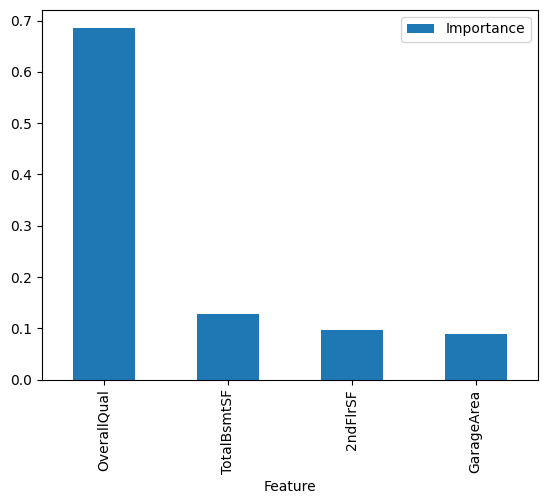

In [22]:
# after data cleaning and feat engine, the feature may space changes
# how much data cleaning and feature engineering does your pipeline have?
data_cleaning_feat_eng_steps = 12
columns_after_data_cleaning_feat_eng = (Pipeline(gb_pipeline.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)

# best_features = columns_after_data_cleaning_feat_eng
best_features = columns_after_data_cleaning_feat_eng[gb_pipeline['feat_selection'].get_support(
)].to_list()

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': columns_after_data_cleaning_feat_eng[gb_pipeline['feat_selection'].get_support()],
    'Importance': gb_pipeline['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

# reassign best features in order
best_features = df_feature_importance['Feature'].to_list()

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{best_features}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

### Evaluate on Train and Test Sets

In [23]:
def regression_performance(X_train, y_train, X_test, y_test, pipeline):
    print("Model Evaluation \n")
    print("* Train Set")
    regression_evaluation(X_train, y_train, pipeline)
    print("* Test Set")
    regression_evaluation(X_test, y_test, pipeline)


def regression_evaluation(X, y, pipeline):
    prediction = pipeline.predict(X)
    print('R2 Score:', r2_score(y, prediction).round(3))
    print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))
    print('Mean Squared Error:', mean_squared_error(y, prediction).round(3))
    print('Root Mean Squared Error:', np.sqrt(
        mean_squared_error(y, prediction)).round(3))
    print("\n")


def regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline, alpha_scatter=0.5):
    pred_train = pipeline.predict(X_train)
    pred_test = pipeline.predict(X_test)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    sns.scatterplot(x=y_train, y=pred_train, alpha=alpha_scatter, ax=axes[0])
    sns.lineplot(x=y_train, y=y_train, color='red', ax=axes[0])
    axes[0].set_xlabel("Actual")
    axes[0].set_ylabel("Predictions")
    axes[0].set_title("Train Set")

    sns.scatterplot(x=y_test, y=pred_test, alpha=alpha_scatter, ax=axes[1])
    sns.lineplot(x=y_test, y=y_test, color='red', ax=axes[1])
    axes[1].set_xlabel("Actual")
    axes[1].set_ylabel("Predictions")
    axes[1].set_title("Test Set")

    plt.show()

Model Evaluation 

* Train Set
R2 Score: 0.947
Mean Absolute Error: 12272.109
Mean Squared Error: 326438737.645
Root Mean Squared Error: 18067.616


* Test Set
R2 Score: 0.808
Mean Absolute Error: 22966.512
Mean Squared Error: 1325716303.82
Root Mean Squared Error: 36410.387




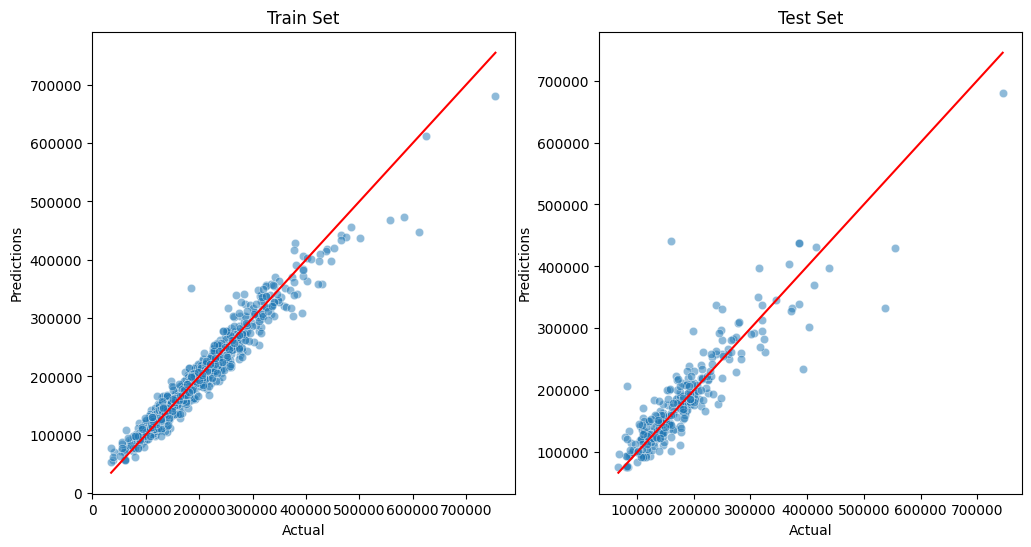

In [24]:
regression_performance(X_train, y_train, X_test, y_test, gb_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, gb_pipeline)

Results suggest overfitting due to the high R2 score on the train set, but as the model is successfully passing the criteria of 0.75 on both train and test set I will consider this a success. I could approach the feature engineering section again to trim different outliers or use different transformations to try and achieve a more consistent R2 score for both train and test sets, however have decided to continue with the model as is.

# Refit pipeline with best features

#### Rewrite Pipeline

In [25]:
def PipelineOptimization(model):
    pipeline_base = Pipeline([
        # Imputation/Data Cleaning
        ('zero_imputer', ArbitraryNumberImputer(arbitrary_number=0, variables=['2ndFlrSF'])),

        # Feature Engineering
        ('yeo_johnson', vt.YeoJohnsonTransformer(variables=['GarageArea',
                                                            'TotalBsmtSF'])),
        ('outlier_winsorizer', Winsorizer(capping_method='iqr',
                                          tail='both',
                                          fold=1.5,
                                          variables=['2ndFlrSF',
                                                     'GarageArea',
                                                     'TotalBsmtSF'])),
        # Feat Scaling
        ("feat_scaling", StandardScaler()),
        # ML algorithms
        ("model", model),
    ])

    return pipeline_base

#### Split Train Test Set, only with best features

In [26]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['SalePrice'], axis=1),
    df['SalePrice'],
    test_size=0.2,
    random_state=0
)

print("* Train set:", X_train.shape, y_train.shape,
      "\n* Test set:",  X_test.shape, y_test.shape)

* Train set: (1168, 23) (1168,) 
* Test set: (292, 23) (292,)


Subset Best Features

In [27]:
X_train = X_train.filter(best_features)
X_test = X_test.filter(best_features)

print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:",  X_test.shape, y_test.shape)
X_train.head(3)

* Train set: (1168, 4) (1168,) 
* Test set: (292, 4) (292,)


,OverallQual,TotalBsmtSF,2ndFlrSF,GarageArea
618,9,1822,0.0,774
870,5,894,0.0,308
92,5,876,0.0,432


#### Grid Search CV – Sklearn

Best Model

In [28]:
gb_models_search

{'GradientBoostingRegressor': GradientBoostingRegressor(random_state=0)}

Best Parameters

In [29]:
gb_best_parameters

{'model__learning_rate': 0.1,
 'model__max_depth': 15,
 'model__max_leaf_nodes': None,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 50,
 'model__n_estimators': 50}

In [30]:
gb_params_search = {
    "GradientBoostingRegressor": {'model__n_estimators': [50],
                                  'model__learning_rate': [0.1],
                                  'model__max_depth': [15],
                                  'model__min_samples_split': [50],
                                  'model__min_samples_leaf': [1],
                                  'model__max_leaf_nodes': [None],
                                  }
  }

GridSearch CV

In [31]:
search = HyperparameterOptimizationSearch(models=gb_models_search,
                                          params=gb_params_search)
search.fit(X_train, y_train, scoring="r2", n_jobs=-1, cv=5)


Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


Check Results

In [32]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__learning_rate,model__max_depth,model__max_leaf_nodes,model__min_samples_leaf,model__min_samples_split,model__n_estimators
0,GradientBoostingRegressor,0.747664,0.793135,0.82441,0.027381,0.1,15,None,1,50,50


Check best model

In [33]:
best_model = grid_search_summary.iloc[0, 0]
best_model

'GradientBoostingRegressor'

Define the best pipeline

In [34]:
best_pipeline = grid_search_pipelines[best_model].best_estimator_
best_pipeline

Pipeline(steps=[('zero_imputer',
                 ArbitraryNumberImputer(arbitrary_number=0,
                                        variables=['2ndFlrSF'])),
                ('yeo_johnson',
                 YeoJohnsonTransformer(variables=['GarageArea',
                                                  'TotalBsmtSF'])),
                ('outlier_winsorizer',
                 Winsorizer(capping_method='iqr', fold=1.5, tail='both',
                            variables=['2ndFlrSF', 'GarageArea',
                                       'TotalBsmtSF'])),
                ('feat_scaling', StandardScaler()),
                ('model',
                 GradientBoostingRegressor(max_depth=15, min_samples_split=50,
                                           n_estimators=50, random_state=0))])

## Assess feature importance

* These are the 4 most important features in descending order. The model was trained on them: 
['OverallQual', 'TotalBsmtSF', '2ndFlrSF', 'GarageArea']


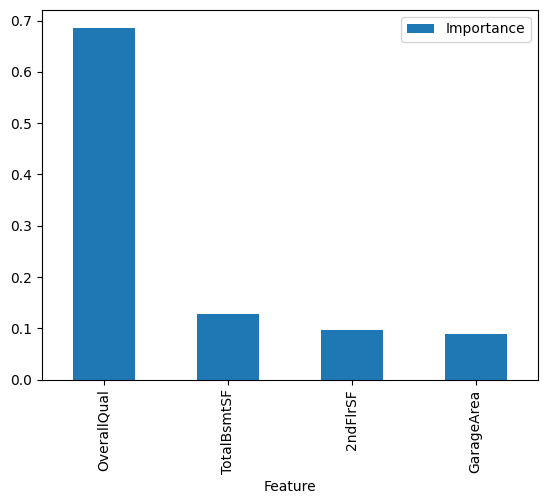

In [35]:
data_cleaning_feat_eng_steps = 3
columns_after_data_cleaning_feat_eng = (Pipeline(best_pipeline.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)

best_features = columns_after_data_cleaning_feat_eng

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': columns_after_data_cleaning_feat_eng,
    'Importance': best_pipeline['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

## Evaluate on Train and Test Sets

The model passes the performance criteria of obtaining an R2 score of at least 0.75 on both train and test set by scoring 0.947 and 0.807 respectively.

Model Evaluation 

* Train Set
R2 Score: 0.947
Mean Absolute Error: 12272.109
Mean Squared Error: 326438737.645
Root Mean Squared Error: 18067.616


* Test Set
R2 Score: 0.807
Mean Absolute Error: 23059.07
Mean Squared Error: 1331580948.378
Root Mean Squared Error: 36490.834




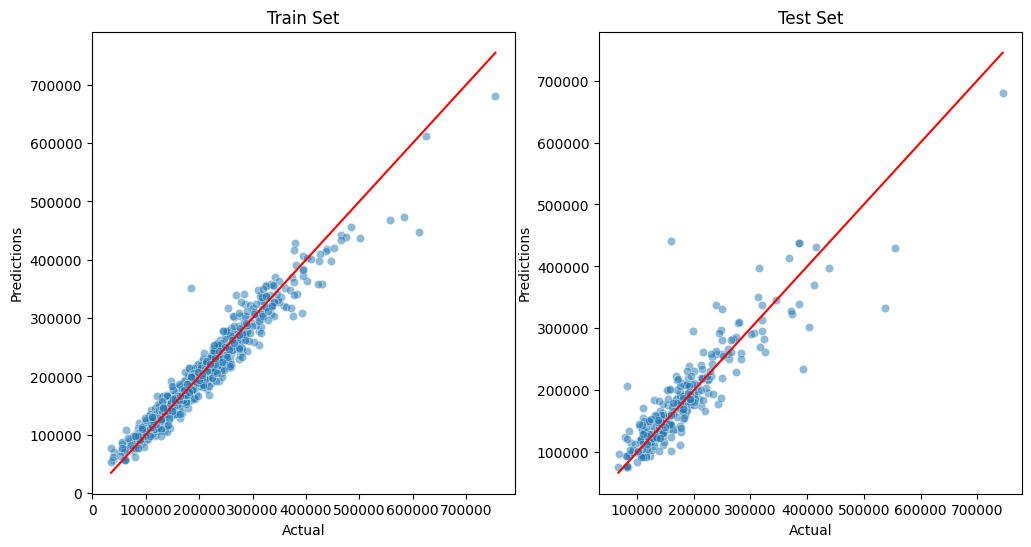

In [36]:
regression_performance(X_train, y_train, X_test, y_test, best_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, best_pipeline)

# Push Files to the repo

We will generate the following files

- Train set
- Test set
- Modelling Pipeline
- Features Importance Plot

In [37]:
version = 'v1'
file_path = f'outputs/ml_pipeline/predict_sale_price/{version}'

try:
    os.makedirs(name=file_path)
except Exception as e:
    print(e)

[Errno 17] File exists: 'outputs/ml_pipeline/predict_sale_price/v1'


## Train Set: features and target

In [38]:
X_train.head()

,OverallQual,TotalBsmtSF,2ndFlrSF,GarageArea
618,9,1822,0.0,774
870,5,894,0.0,308
92,5,876,0.0,432
817,8,1568,0.0,857
302,7,1541,0.0,843


In [39]:
X_train.to_csv(f"{file_path}/X_train.csv", index=False)

In [40]:
y_train

618     314813
870     109500
92      163500
817     271000
302     205000
         ...  
763     337000
835     128000
1216    112000
559     234000
684     221000
Name: SalePrice, Length: 1168, dtype: int64

In [41]:
y_train.to_csv(f"{file_path}/y_train.csv", index=False)

## Test Set: features and target

In [42]:
X_test.head()

,OverallQual,TotalBsmtSF,2ndFlrSF,GarageArea
529,6,2035,0.0,484
491,6,806,620.0,240
459,5,709,224.0,352
279,7,1160,866.0,505
655,6,525,NaN,264


In [43]:
X_test.to_csv(f"{file_path}/X_test.csv", index=False)

In [44]:
y_test

529     200624
491     133000
459     110000
279     192000
655      88000
         ...  
326     324000
440     555000
1387    136000
1323     82500
61      101000
Name: SalePrice, Length: 292, dtype: int64

In [45]:
y_test.to_csv(f"{file_path}/y_test.csv", index=False)

## Modelling Pipeline

In [46]:
best_pipeline

Pipeline(steps=[('zero_imputer',
                 ArbitraryNumberImputer(arbitrary_number=0,
                                        variables=['2ndFlrSF'])),
                ('yeo_johnson',
                 YeoJohnsonTransformer(variables=['GarageArea',
                                                  'TotalBsmtSF'])),
                ('outlier_winsorizer',
                 Winsorizer(capping_method='iqr', fold=1.5, tail='both',
                            variables=['2ndFlrSF', 'GarageArea',
                                       'TotalBsmtSF'])),
                ('feat_scaling', StandardScaler()),
                ('model',
                 GradientBoostingRegressor(max_depth=15, min_samples_split=50,
                                           n_estimators=50, random_state=0))])

In [47]:
joblib.dump(value=best_pipeline, filename=f"{file_path}/clf_pipeline.pkl")

['outputs/ml_pipeline/predict_sale_price/v1/clf_pipeline.pkl']

## Feature importance plot

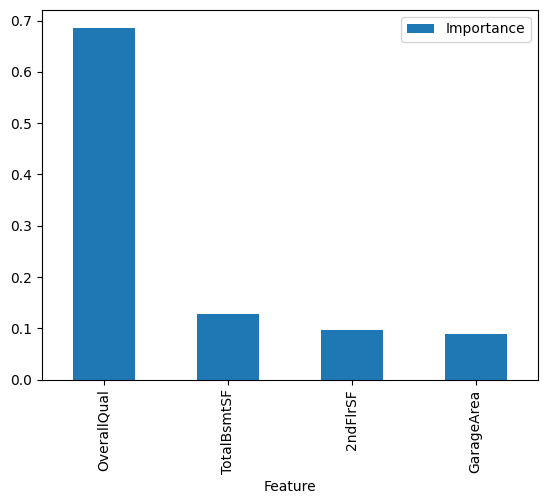

In [48]:
df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

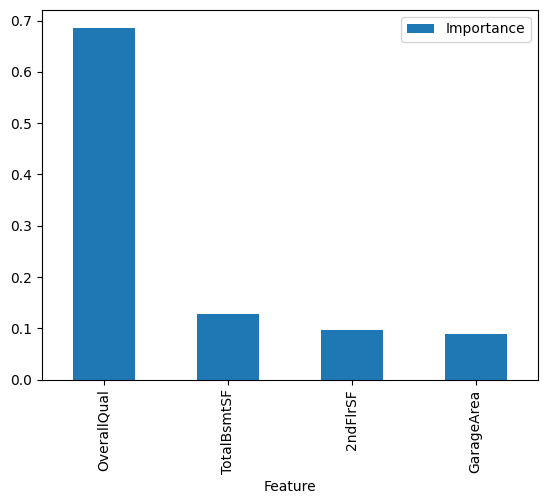

In [49]:
df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.savefig(f'{file_path}/features_importance.png', bbox_inches='tight')